# Numerical study of the LUCJ initialization and compressed $t$ amplitudes

In [ ]:
from pathlib import Path
import scipy.optimize
import numpy as np
import pyscf
import pyscf.gto
import pyscf.scf
import pyscf.mcscf
import pyscf.cc
import ffsim
import time

molecule = "n2"
basis = "sto-6g"
atom = lambda R: [["N",(0.0,0,0)],["N",(R,0,0)]]
n_f = 2 # frozen core: n_f = 2

mol = pyscf.gto.Mole()
mol.build(atom=atom(1.1), basis=basis, symmetry="Dooh", verbose=0)
active_space = range(n_f, mol.nao_nr())

scf = pyscf.scf.RHF(mol).run()
norb = len(active_space)
nelec = int(sum(scf.mo_occ[active_space]))
nelec_alpha = (nelec + mol.spin)//2
nelec_beta  = (nelec - mol.spin)//2
cas = pyscf.mcscf.RCASCI(scf, ncas=norb, nelecas=nelec)
mo_coeff = cas.sort_mo(active_space, base=0)
ccsd = pyscf.cc.RCCSD(scf, frozen=[i for i in range(mol.nao_nr()) if i not in active_space])
ccsd.kernel()
mol_data = ffsim.MolecularData.from_scf(scf, active_space=active_space)
norb = mol_data.norb
nelec = mol_data.nelec
H = ffsim.linear_operator(mol_data.hamiltonian, norb=norb, nelec=nelec)
Phi0 = ffsim.hartree_fock_state(norb, nelec)
cas.fix_spin_(ss=0)
cas.kernel(mo_coeff=mo_coeff)
E_FCI = cas.e_tot

pairs_aa = [(p, p+1) for p in range(norb-1)]
pairs_ab = [(p, p)   for p in range(norb)]

error_lucj_unopt = []; error_lucj_opt = []; error_lucj_opt_reg = []
for k in range(1,50,5):
    lucj_unopt = ffsim.UCJOpSpinBalanced.from_t_amplitudes(t2=ccsd.t2,t1=ccsd.t1,n_reps=k,interaction_pairs=(pairs_aa,pairs_ab))
    psi = ffsim.apply_unitary(Phi0, lucj_unopt, norb=norb, nelec=nelec)
    err_unopt = abs(E_FCI - float(np.vdot(psi, H @ psi).real))
    error_lucj_unopt.append(err_unopt)    
    
    lucj_opt = ffsim.UCJOpSpinBalanced.from_t_amplitudes(t2=ccsd.t2,t1=ccsd.t1,n_reps=k,interaction_pairs=(pairs_aa,pairs_ab), 
                                                         optimize=True, tol = 1e-12, options=dict(maxiter=1000))
    psi = ffsim.apply_unitary(Phi0, lucj_opt, norb=norb, nelec=nelec)
    err_opt = abs(E_FCI - float(np.vdot(psi, H @ psi).real))
    error_lucj_opt.append(err_opt)    

    lucj_opt_reg = ffsim.UCJOpSpinBalanced.from_t_amplitudes(t2=ccsd.t2,t1=ccsd.t1,n_reps=k,interaction_pairs=(pairs_aa,pairs_ab), 
                                                             optimize=True, regularization = 0.1, tol = 1e-12, options=dict(maxiter=1000))
    psi = ffsim.apply_unitary(Phi0, lucj_opt_reg, norb=norb, nelec=nelec)
    err_opt_reg = abs(E_FCI - float(np.vdot(psi, H @ psi).real))
    error_lucj_opt_reg.append(err_opt_reg)
 

In [ ]:
error_ucj_unopt = []

for k in range(1,50,5):
    ucj_unopt = ffsim.UCJOpSpinBalanced.from_t_amplitudes(t2=ccsd.t2,t1=ccsd.t1,n_reps=k)
    psi = ffsim.apply_unitary(Phi0, ucj_unopt, norb=norb, nelec=nelec)
    err_unopt = abs(E_FCI - float(np.vdot(psi, H @ psi).real))
    error_ucj_unopt.append(err_unopt)    

In [ ]:
import matplotlib.pyplot as plt
ks = range(1,50,5)
plt.semilogy(ks, error_lucj_unopt, "s--", label=r"un-opt $\tilde t_{ijab}$")
plt.semilogy(ks, error_lucj_opt, "^--", label=r"opt $\tilde t_{ijab}$")
plt.semilogy(ks, error_lucj_opt_reg, "x--", label=r"opt+reg $\tilde t_{ijab}, \lambda = 0.1$")
plt.semilogy(ks, error_ucj_unopt, "o--", label=r"full $t_{ijab}$")

plt.xlabel(r"$k$ repetitions")
plt.ylabel(r"$|E_{\text{FCI}}- E_{\text{ansatz}}|$")
plt.legend()
plt.show()

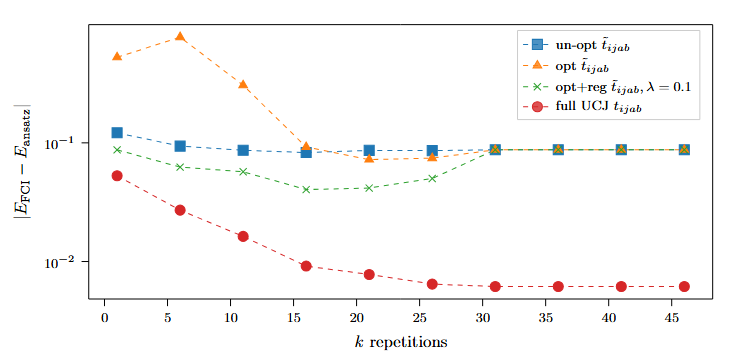